# CAD integration

In this task, we will learn how to run CAD-based simulations.

Our example case will be a 3D ITER-like monoblock made of three different materials (tungsten, cucrzr, and copper).

For this example, the mesh was created with [SALOME](https://www.salome-platform.org/) but other meshing software can be used like [GMSH](https://gmsh.info/).

Using [meshio](https://github.com/nschloe/meshio), the mesh file (here a .med file) can be converted to .xdmf format, readable by FESTIM.

We wrote the following function `convert_med_to_xdmf` to convert .med files to .xdmf.

In [1]:
import meshio


def convert_med_to_xdmf(
    med_file,
    cell_file="mesh_domains.xdmf",
    facet_file="mesh_boundaries.xdmf",
    cell_type="tetra",
    facet_type="triangle",
):
    """Converts a MED mesh to XDMF
    Args:
        med_file (str): the name of the MED file
        cell_file (str, optional): the name of the file containing the
            volume markers. Defaults to "mesh_domains.xdmf".
        facet_file (str, optional): the name of the file containing the
            surface markers.. Defaults to "mesh_boundaries.xdmf".
        cell_type (str, optional): The topology of the cells. Defaults to "tetra".
        facet_type (str, optional): The topology of the facets. Defaults to "triangle".
    Returns:
        dict, dict: the correspondance dict, the cell types
    """
    msh = meshio.read(med_file)

    correspondance_dict = msh.cell_tags

    cell_data_types = msh.cell_data_dict["cell_tags"].keys()

    for mesh_block in msh.cells:
        if mesh_block.type == cell_type:

            meshio.write_points_cells(
                cell_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][cell_type]]},
            )
        elif mesh_block.type == facet_type:
            meshio.write_points_cells(
                facet_file,
                msh.points,
                [mesh_block],
                cell_data={"f": [-1 * msh.cell_data_dict["cell_tags"][facet_type]]},
            )

    return correspondance_dict, cell_data_types

The subdomains (volumes and surfaces) in the .med file were given tags.

This is very important to be able to assign materials properties and boundary conditions to these subdomains.

The correspondance between tags and subdomains is returned by `convert_med_to_xdmf`.
Here for example, the volume corresponding to `tungsten` is the tag `6`.

In [2]:
correspondance_dict, cell_data_types = convert_med_to_xdmf(
    "task08/mesh.med",
    cell_file="task08/mesh_domains.xdmf",
    facet_file="task08/mesh_boundaries.xdmf",
)

print(correspondance_dict)

{np.int64(-6): ['tungsten'], np.int64(-7): ['cu'], np.int64(-8): ['cucrzr'], np.int64(-9): ['top_surface'], np.int64(-10): ['cooling_surface'], np.int64(-11): ['poloidal_gap'], np.int64(-12): ['toroidal_gap'], np.int64(-13): ['bottom']}


In [3]:
import festim as F

tungsten = F.Material(
    D_0=4.1e-7,
    E_D=0.39,
    K_S_0=1.87e24,
    E_K_S=1.04,
    thermal_conductivity=100,
)

copper = F.Material(
    D_0=6.6e-7,
    E_D=0.387,
    K_S_0=3.14e24,
    E_K_S=0.572,
    thermal_conductivity=350,
)

cucrzr = F.Material(
    D_0=3.92e-7, E_D=0.418, K_S_0=4.28e23, E_K_S=0.387, thermal_conductivity=350
)

The converted .xdmf files can then be imported in FESTIM using the `MeshFromXDMF` class:

In [4]:
mesh = F.MeshFromXDMF(
    volume_file="task08/mesh_domains.xdmf", facet_file="task08/mesh_boundaries.xdmf"
)

In [5]:
tungsten_volume = F.VolumeSubdomain(id=6, material=tungsten)
copper_volume = F.VolumeSubdomain(id=7, material=copper)
cucrzr_volume = F.VolumeSubdomain(id=8, material=cucrzr)
top_surface = F.SurfaceSubdomain(id=9)
cooling_surface = F.SurfaceSubdomain(id=10)
poloidal_gap = F.SurfaceSubdomain(id=11)
toroidal_gap = F.SurfaceSubdomain(id=12)
bottom = F.SurfaceSubdomain(id=13)

all_subdomains = [
    tungsten_volume,
    copper_volume,
    cucrzr_volume,
    top_surface,
    cooling_surface,
    poloidal_gap,
    toroidal_gap,
    bottom,
]

In [6]:
heat_transfer_problem = F.HeatTransferProblem()
heat_transfer_problem.subdomains = all_subdomains
heat_transfer_problem.mesh = mesh

heat_flux_top = F.HeatFluxBC(subdomain=top_surface, value=10e6)
convective_flux_coolant = F.HeatFluxBC(
    subdomain=cooling_surface, value=lambda T: 7e04 * (323 - T)
)

heat_transfer_problem.boundary_conditions = [heat_flux_top, convective_flux_coolant]

heat_transfer_problem.settings = F.Settings(
    atol=1e-10,
    rtol=1e-10,
    transient=False,
)
heat_transfer_problem.initialise()
heat_transfer_problem.run()

In [7]:
my_model = F.HTransportProblemPenalty()


my_model.subdomains = all_subdomains

H = F.Species("H", subdomains=my_model.volume_subdomains)
my_model.species = [H]

my_model.mesh = mesh

my_model.surface_to_volume = {
    top_surface: tungsten_volume,
    cooling_surface: cucrzr_volume,
    poloidal_gap: tungsten_volume,
    toroidal_gap: tungsten_volume,
    bottom: tungsten_volume,
}
my_model.interfaces = [
    # these are not in the XDMF so need to mark them in SALOME
    F.Interface(id=14, subdomains=(tungsten_volume, copper_volume)),
    F.Interface(id=15, subdomains=(copper_volume, cucrzr_volume)),
]

Using the tags provided by `correspondance_dict`, we can create materials and assign them to the simulation:

Similarily, the surface tags are used to create boundary conditions:

In [8]:
import ufl

phi = 1.61e22
R_p = 9.52e-10
implantation_flux_top = F.FixedConcentrationBC(
    subdomain=top_surface,
    value=lambda T: phi * R_p / (tungsten.D_0 * ufl.exp(-tungsten.E_D / F.k_B / T)),
    species=H,
)

recombination_fluxes = [
    F.FixedConcentrationBC(subdomain=surf, value=0, species=H)
    for surf in [toroidal_gap, poloidal_gap]
]

my_model.boundary_conditions = [implantation_flux_top] + recombination_fluxes

my_model.temperature = heat_transfer_problem.u  # FIXME https://fenicsproject.discourse.group/t/interpolate-expression-on-submesh-with-parent-mesh-function/17467

my_model.settings = F.Settings(
    atol=1e10,
    rtol=1e-10,
    transient=False,
)

my_model.initialise()
my_model.run()

RuntimeError: Cells lists have different lengths.

## Post processing

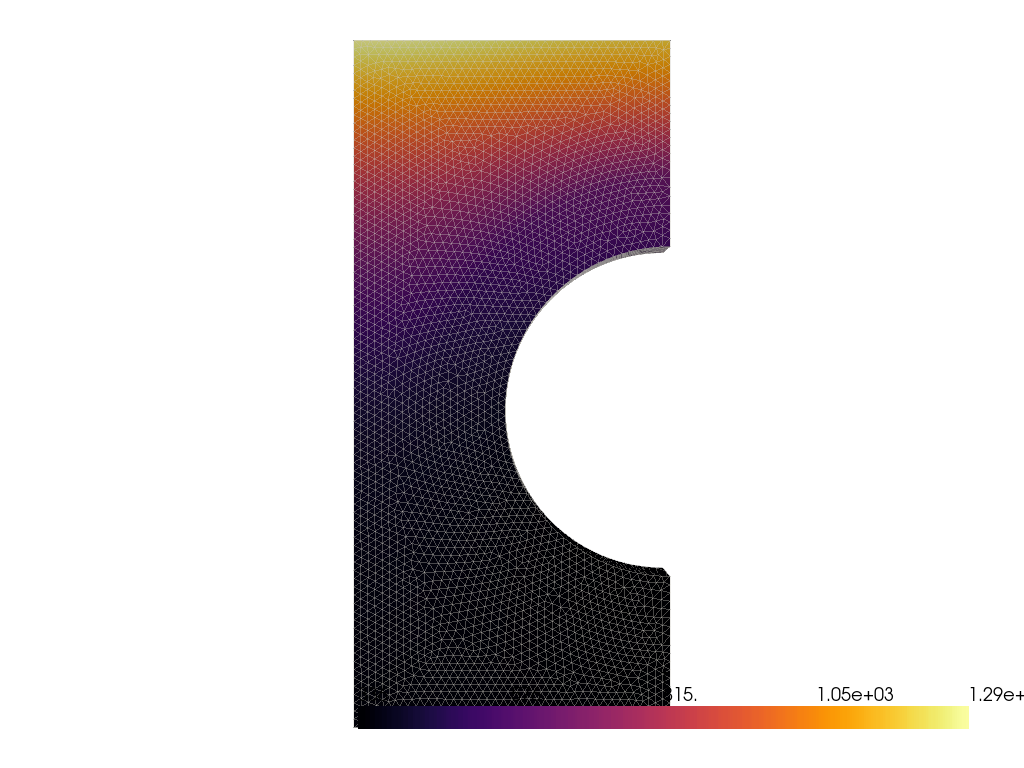

In [ ]:
from dolfinx import plot
import pyvista

T = heat_transfer_problem.u

topology, cell_types, geometry = plot.vtk_mesh(T.function_space)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.point_data["T"] = T.x.array.real
u_grid.set_active_scalars("T")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, cmap="inferno", show_edges=False)
u_plotter.add_mesh(u_grid, style="wireframe", color="white", opacity=0.2)

contours = u_grid.contour(9)
u_plotter.add_mesh(contours, color="white")

u_plotter.view_xy()

if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("temperature.png")

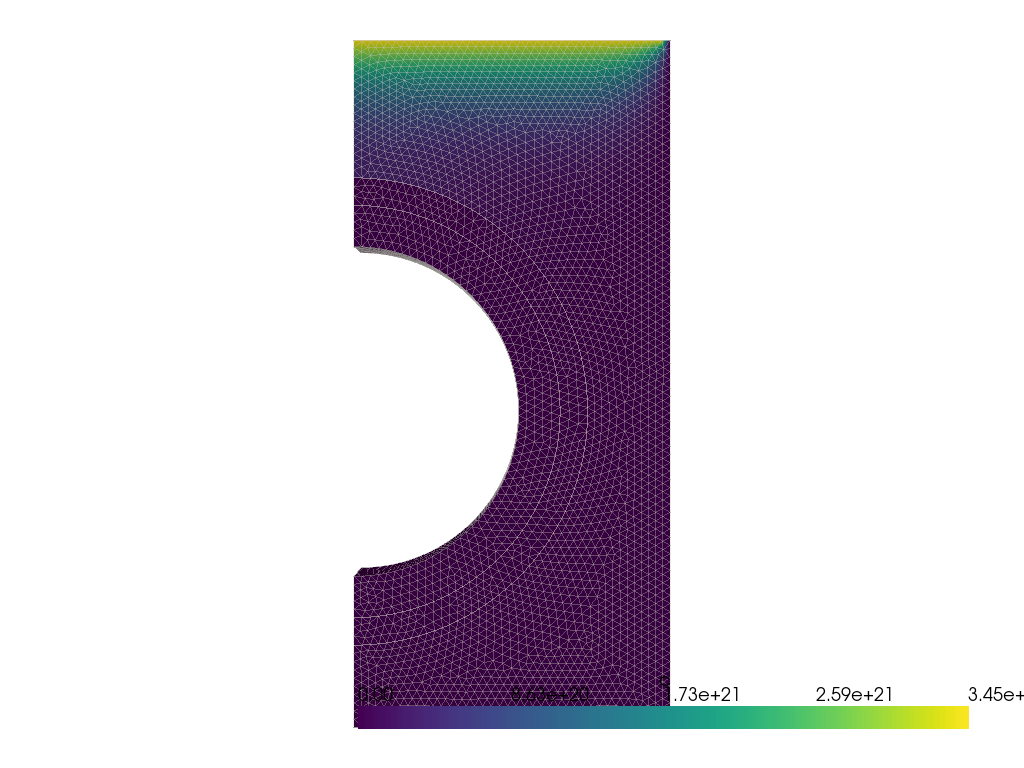

In [ ]:
u_plotter = pyvista.Plotter()

for vol in my_model.volume_subdomains:
    sol = H.subdomain_to_post_processing_solution[vol]

    topology, cell_types, geometry = plot.vtk_mesh(sol.function_space)
    u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data["c"] = sol.x.array.real
    u_grid.set_active_scalars("c")
    u_plotter.add_mesh(u_grid, cmap="viridis", show_edges=False)
    u_plotter.add_mesh(u_grid, style="wireframe", color="white", opacity=0.2)

# # contours = u_grid.contour(9)
# u_plotter.add_mesh(contours, color="white")

# u_plotter.view_xz(negative=True)
u_plotter.view_xy(negative=True)

if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("concentration.png")